In [1]:
import sys
sys.path.append('./../src/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
from MLE_drift import *

import copy
import torch
import math
import numpy as np

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [ ]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [ ]:
num_samples = 15
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [ ]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)



In [ ]:
plot_trajectories_2(Xts, t, remove_time=True)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

In [ ]:
gp_ou_drift = fit_drift(Xts,N,dt)

t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=X_0, dt=dt, N=N) # Solver using GP predicted drift
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

In [ ]:

Xbts = copy.deepcopy(Xts)
Xbts[:,:,0] = Xbts[:,:,0].flip(1) # Reverse the series

gp_ou_drift = fit_drift(Xbts,N,dt)
tb_hat, Xbts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=Xbts[:,0,0].reshape((-1,1)), dt=dt, N=N) # Solver using GP predicted drift

fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r');

#  IPFP

In [ ]:
num_samples = 30
X_0 = torch.distributions.normal.Normal(loc=0, scale=0.5).sample((num_samples, 1)) #.reshape(num_samples, dim,-1)

X_1_a = torch.distributions.normal.Normal(loc=1.8, scale=0.6**2).sample((num_samples//2, 1)) 
X_1_b = torch.distributions.normal.Normal(loc=-1.9, scale=0.6**2).sample((num_samples//2, 1))
X_1 = torch.cat((X_1_a,X_1_b))

In [ ]:
plt.scatter([0]*X_0.shape[0],X_0)
plt.scatter([1]*X_0.shape[0],X_1)

In [ ]:
result = MLE_IPFP(X_0,X_1)

In [ ]:
T,M,T2,M2 = result[-1]
plot_trajectories_2(M,T)
plot_trajectories_2(M2,  T2)

# 2D example

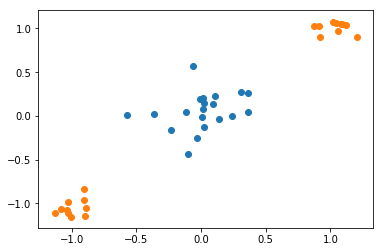

In [20]:
num_samples = 10
N = 10
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)*0.05).sample((num_samples*2,1)).reshape((-1,2))

X_1_a = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2),torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1_b = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2)*-1,torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1 = torch.cat((X_1_a,X_1_b))

# TO reshape
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])


In [21]:

result = MLE_IPFP(X_0,X_1,N=N,sigma=0.3)

100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


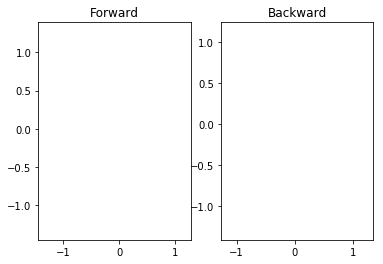

In [31]:
fig, (ax1, ax2) =  plt.subplots(1, 2)
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')
